In [1]:
#%matplotlib ipympl
#see https://stackoverflow.com/questions/50149562/jupyterlab-interactive-plot for how to zoom on plots!

In [4]:
import scipy.signal
import scipy.fftpack
import numpy as np
import struct
import matplotlib.pyplot as plt
import math
import multiprocessing
import json
from astropy.time import Time,TimeDelta
from astroquery.jplhorizons import Horizons

In [48]:
#metaname = 'vger1-2010-07-14-xpol.sigmf-meta'
#filename = 'vger1-2010-07-14-xpol.sigmf-data'
metaname = '/disk2/voyager/voyager-58620.540722.meta'
filename = '/disk2/voyager/voyager-58620.540722.16ic'
#metaname = 'blc07_guppi_57650_67573_Voyager1_pol1.sigmf-meta'
#filename = 'blc07_guppi_57650_67573_Voyager1_pol1.sigmf-data'
observatory_code = -72 #set to -72 for HCRO, -9 for GBT

In [49]:
start_time = 0
end_time = 120
nsecs = end_time-start_time #total amount of time to read from the file -- integration time
fftlen = 32768 #fftlen is FFT length on decimated data
bin_target = 1.0 #frequency bin size (data will be decimated to this bin width)

In [50]:
metadata = {}
with open(metaname, 'r') as mf:
    metajson = json.load(mf)
    metadata["samp_rate"] = float(metajson["global"]["core:sample_rate"])
    if metadata["samp_rate"] < 0:
        invert_spectrum=True
        metadata["samp_rate"] = abs(metadata["samp_rate"])
    else:
        invert_spectrum=False
    metadata["frequency"] = float(metajson["captures"][0]["core:frequency"])
    metadata["date"] = metajson["captures"][0]["core:datetime"]
    metadata["format"] = {"ci16": np.int16, "ci8_be": np.int8}[metajson["global"]["core:datatype"]]

In [51]:
sig_ctr = 8420.432097e6 #Voyager 1 center freq
rec_ctr   = metadata["frequency"] #center frequency of the recording
c = 2.99792458e8

starttime = Time(metadata["date"], format="isot")+TimeDelta(start_time, format="sec")
doppler_deltat = 600 #time duration to use in Doppler drift estimate
jdtimes = [starttime, starttime+TimeDelta(doppler_deltat,format="sec")]
query = Horizons(id="Voyager 1",
                 location="%s" % observatory_code,
                 epochs=[jdtime.jd for jdtime in jdtimes],
                 id_type="majorbody")
eph = query.ephemerides()
dopplers = [sig_ctr*(c/(c+1000*i['delta_rate'])) for i in eph]
sig_start = dopplers[0]
drift_est = (dopplers[1]-dopplers[0])/doppler_deltat
offset = sig_start-rec_ctr #offset frequency at the start of the recording
candidate_drifts = np.linspace(drift_est-0.1, drift_est+0.1, 20)
print("Estimated center frequency: %.2f" % sig_start)
print("Estimated Doppler drift rate: %.3f/s" % drift_est)
print("Looking at %i drift rates between %.4fHz/s and %.4fHz/s" % (len(candidate_drifts), candidate_drifts[0], candidate_drifts[-1]))

Estimated center frequency: 8420188396.87
Estimated Doppler drift rate: -0.572/s
Looking at 20 drift rates between -0.6715Hz/s and -0.4715Hz/s


In [52]:
samplesize=np.dtype(metadata["format"]).itemsize
samp_rate = metadata["samp_rate"]
decim_rate = int(samp_rate/(bin_target*fftlen))
num_integrations = int(samp_rate*nsecs/decim_rate/fftlen)
print("Number of integrations: %i" % num_integrations)
input_veclen = int(fftlen * decim_rate)
print("Time per integration: %.2fs" % (fftlen*decim_rate/samp_rate))
print("FFT length: %i" % fftlen)
print("Decimation factor: %i" % decim_rate)
bin_size = samp_rate/fftlen/decim_rate
print("Bin size: %.2f" % bin_size)

Number of integrations: 120
Time per integration: 1.00s
FFT length: 32768
Decimation factor: 317
Bin size: 1.00


In [53]:
def try_acquisition(drift):
    #we'll store integrations here
    f = open(filename, 'rb')
    sumvector = np.zeros(fftlen, dtype=np.complex128)
    f.seek(int(start_time*samp_rate*samplesize*2))
    for i in range(num_integrations):
        vec = np.fromstring(f.read(input_veclen*2*samplesize), dtype=metadata["format"]).astype(np.float64)/(2**(samplesize*8))
        cvec = vec.view(np.complex128)
        if invert_spectrum:
            cvec = np.conj(cvec)
        freqvec = np.linspace(offset+drift*i*input_veclen/samp_rate,
                            offset+drift*(i+1)*input_veclen/samp_rate,
                            input_veclen)
        freqshiftvec = np.exp(1j*(-2*math.pi*freqvec*np.arange(input_veclen)/samp_rate))
        rvec = cvec * freqshiftvec
        if(decim_rate > 1):
            dvec = scipy.signal.resample_poly(rvec, 1, decim_rate)
        else:
            dvec = rvec
        #W = scipy.signal.blackman(len(dvec))
        W = np.ones(fftlen)
        H = scipy.fftpack.fft(dvec*W, len(dvec))
        Ha = scipy.fftpack.fftshift(H)
        sumvector += np.abs(Ha)

    Hl = 20*np.log10(np.abs(sumvector))
    peak = np.max(Hl)
    print("Drift %.3f: %.2fdB" % (drift, peak))
    return (drift, peak, Hl)

In [54]:
p = multiprocessing.Pool(20)
correlations = p.map(try_acquisition, candidate_drifts)
print("Done.")

/home/nick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/home/nick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/home/nick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/home/nick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/home/nick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is depr

Drift -0.640: 10.03dB
Drift -0.587: 9.99dB
Drift -0.472: 10.22dB
Drift -0.493: 9.89dB
Drift -0.619: 10.00dB
Drift -0.545: 10.13dB
Drift -0.672: 10.07dB
Drift -0.503: 10.31dB
Drift -0.482: 10.11dB
Drift -0.661: 10.10dB
Drift -0.598: 9.93dB
Drift -0.629: 10.02dB
Drift -0.514: 10.10dB
Drift -0.608: 10.08dB
Drift -0.577: 9.98dB
Drift -0.650: 10.05dB
Drift -0.535: 10.17dB
Drift -0.556: 10.21dB
Drift -0.566: 10.04dB
Drift -0.524: 9.98dB
Done.


In [55]:
best = max(correlations,key=lambda x: x[1])
best_drift = best[0]
best_corr  = best[1]
Hl = best[2]
freqs = np.linspace(-samp_rate/decim_rate/2, samp_rate/decim_rate/2, fftlen)
c_index = Hl.tolist().index(best_corr)
c_offset = freqs[c_index]
N0_arr = np.delete(Hl, c_index)
N0 = 10*np.log10(np.sum(10**(N0_arr/10))/fftlen) #this should exclude the signal bin, to be exact
best_cn0 = best_corr - N0

print("Best candidate carrier found at %.2fHz offset" % c_offset)
print("Best drift rate: %.5fHz/s" % best_drift)
print("Best correlation: %.2fdB" % best_corr)
print("Best noise power: %.2fdB" % N0)
print("Best C/N0: %.2fdB (%.2fdBHz)" % (best_cn0, best_cn0*bin_size))

Best candidate carrier found at -9959.73Hz offset
Best drift rate: -0.50311Hz/s
Best correlation: 10.31dB
Best noise power: 8.31dB
Best C/N0: 2.00dB (2.00dBHz)


<Figure size 432x288 with 0 Axes>

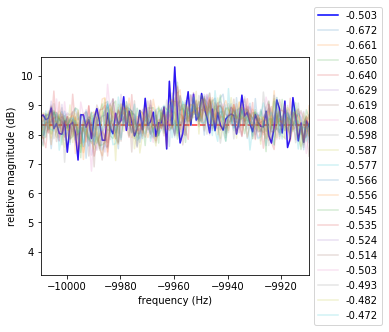

In [56]:
plt.clf()
fig,ax = plt.subplots()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
plt.plot(freqs, Hl, color='blue', label="%.3f" % best_drift)
plt.xlim(c_offset-50, c_offset+50)
for p in correlations:
    plt.plot(freqs, p[2], alpha=0.2, label="%.3f" % p[0])
plt.ylabel('relative magnitude (dB)')
plt.xlabel('frequency (Hz)')
plt.hlines(N0, min(freqs), max(freqs), color='red', alpha=0.8, linestyle='dashed')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.show()